In [ ]:
!pip install pandas scikit-learn torch transformers

In [ ]:
import seaborn as sns
import pandas as pd
from sklearn.model_selection import train_test_split
from transformers import BertForSequenceClassification, BertTokenizer
from torch.utils.data import DataLoader, TensorDataset
import torch
from textblob import TextBlob
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score, precision_score, recall_score
import matplotlib.pyplot as plt

In [ ]:
# Load the dataset
data = pd.read_csv('/content/final_dataset.csv')

# Apply the sentiment analysis function & create a new 'polarity' column
data['polarity'] = data['preprocessed_text_tokenized'].apply(lambda x: TextBlob(x).sentiment.polarity)

# Assign labels based on polarity
data['polarity_label'] = data['polarity'].apply(lambda x: 1 if x > 0 else 0 if x == 0 else 2)

# Split the dataset into training and testing sets
train_data, test_data, train_labels, test_labels = train_test_split(
    data['preprocessed_text_tokenized'], data['polarity_label'], test_size=0.2, random_state=42)

In [ ]:
# Load the pre-trained BERT model and tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3)  # 3 classes

# Tokenize and format the input data
train_encodings = tokenizer(list(train_data), truncation=True, padding=True, return_tensors='pt')
test_encodings = tokenizer(list(test_data), truncation=True, padding=True, return_tensors='pt')

# Convert pandas Series to lists
train_input_ids = train_encodings['input_ids'].tolist()
train_attention_mask = train_encodings['attention_mask'].tolist()
train_labels_list = train_labels.tolist()

# Create PyTorch DataLoader
train_dataset = TensorDataset(torch.tensor(train_input_ids), torch.tensor(train_attention_mask), torch.tensor(train_labels_list))

# Similar conversion for the test dataset
test_input_ids = test_encodings['input_ids'].tolist()
test_attention_mask = test_encodings['attention_mask'].tolist()
test_labels_list = test_labels.tolist()

test_dataset = TensorDataset(torch.tensor(test_input_ids), torch.tensor(test_attention_mask), torch.tensor(test_labels_list))


train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Training parameters
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
criterion = torch.nn.CrossEntropyLoss()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Training loop
epochs = 1
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

for epoch in range(epochs):
    model.train()
    for batch in DataLoader(train_dataset, batch_size=16, shuffle=True):
        input_ids, attention_mask, labels = batch
        input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()

In [ ]:
#Training accuracy
model.eval()
with torch.no_grad():
    train_preds = []
    train_labels_list = []
    for batch in DataLoader(train_dataset, batch_size=8, shuffle=False):
        input_ids, attention_mask, labels = batch
        input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        preds = torch.argmax(logits, dim=1).cpu().numpy()

        train_preds.extend(preds)
        train_labels_list.extend(labels.cpu().numpy())

train_accuracy = accuracy_score(train_labels_list, train_preds)
print(f'Training Accuracy: {train_accuracy * 100:.2f}%')

Training Accuracy: 98.12%


In [ ]:
# Evaluate on the test set
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for batch in test_dataloader:
        input_ids, attention_mask, labels = batch
        input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        _, preds = torch.max(logits, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Save the test predictions in a new CSV file
result_df = pd.DataFrame({
    'Text': test_data,
    'Actual_Labels': all_labels,
    'Predicted_Labels': all_preds
})

result_df.to_csv('/content/test_predictions_BERT.csv', index=False)

# Calculate and print metrics
accuracy = accuracy_score(all_labels, all_preds)
print(f'Testing Accuracy: {accuracy * 100:.2f}%')

Testing Accuracy: 97.65%


Confusion Matrix:
[[ 8032    89    71]
 [   22 10919   162]
 [   69   144  4152]]


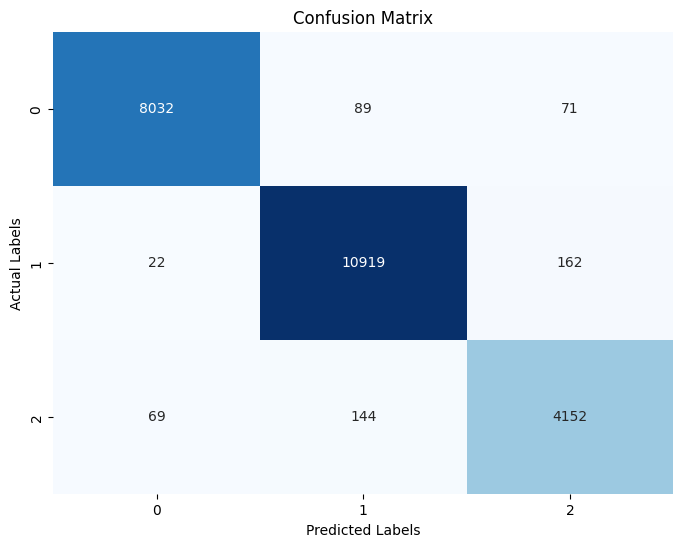

In [ ]:
# Confusion Matrix
conf_matrix = confusion_matrix(all_labels, all_preds)
print('Confusion Matrix:')
print(conf_matrix)

# Visualization of Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=[0, 1, 2], yticklabels=[0, 1, 2])
plt.xlabel('Predicted Labels')
plt.ylabel('Actual Labels')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# Classification Report
print('Classification Report:')
print(classification_report(all_labels, all_preds, target_names=['Class 0', 'Class 1', 'Class 2']))


Classification Report:
              precision    recall  f1-score   support

     Class 0       0.99      0.98      0.98      8192
     Class 1       0.98      0.98      0.98     11103
     Class 2       0.95      0.95      0.95      4365

    accuracy                           0.98     23660
   macro avg       0.97      0.97      0.97     23660
weighted avg       0.98      0.98      0.98     23660



In [ ]:
import pandas as pd

test_predictions = pd.read_csv('/content/test_predictions_BERT.csv')

positive_count = (test_predictions['Actual_Labels'] == 1).sum()
negative_count = (test_predictions['Actual_Labels'] == 2).sum()
neutral_count = (test_predictions['Actual_Labels'] == 0).sum()

total_count = len(test_predictions)

# Calculate the percentages
positive_percentage = (positive_count / total_count) * 100
negative_percentage = (negative_count / total_count) * 100
neutral_percentage = (neutral_count / total_count) * 100

print(f"Positive Percentage: {positive_percentage:.2f}%")
print(f"Negative Percentage: {negative_percentage:.2f}%")
print(f"Neutral Percentage: {neutral_percentage:.2f}%")


Positive Percentage: 46.93%
Negative Percentage: 18.45%
Neutral Percentage: 34.62%
